# Quantitative Macroeconomics - Homework IV
## Parts II.4.1. & II.4.2.
Ivana Kaloyanova Ganeva

*December, 2020*

In [1]:
# Preliminary to the preliminaries if package quantecon is missing:
# pip install quantecon

In [3]:
# SOME PRELIMINARIES:
# (loading the necessary libraries)
import pandas as pd
import numpy as np
import scipy as sp
from numpy import vectorize
from itertools import product
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.interpolate import BSpline 
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import quantecon as qe
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)
np.seterr(divide = 'ignore', invalid = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

The codes presented herewith are an extension to the codes presented in Part 1. of my submission, where I consider two separate cases - certainty/uncertainty, as required.

In [11]:
# transfering some of the relevant codes/parameters from Part 1:

# function to calculate the preferences, based on the choice of preferences
def preferences(c_bar, c, pref_type = 'quadratic', sigma = 0.5):
    if pref_type == 'quadratic':
        u = -0.5*(c-c_bar)**2
    elif pref_type == 'CRRA':
        if c >= 0:
            u = (c**(1-sigma)-1)/(1-sigma)
        else:
            u = -10000
    else:
        u = 'Please, select either quadratic or CRRA utility.'
    return u

# Model parameters:
r = 0.04 
rho = 0.06
w = 1
gamma = 0
sigma_y = 0 # changing as advised

# Also adding the tolerance for convergence:
eps = 10**(-3)

# Future discount rate:
beta = 1/(1+rho)

# Markov Process transition matrix:
pi = np.array([((1+gamma)/2, (1-gamma)/2),((1-gamma)/2, (1+gamma)/2)])

# Income:
Y = np.array([1 - sigma_y, 1 + sigma_y]) # note to self: 
                               # nest this in a function where the user can choose cardinality N, sigma_y etc
c_bar_sat = 100 # avoiding saturation as required -> this could be altered

# Assets grid for following period:
A = np.linspace(((-(1+r)/r)*Y[0]), 50, 80) # Replacing with (1+r)/r 
                                           # in order to find solution when borrowing not allowed

### II.4.1. Partial Equilibrium with Certainty

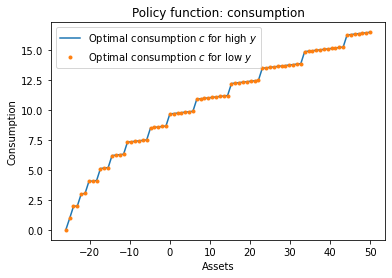

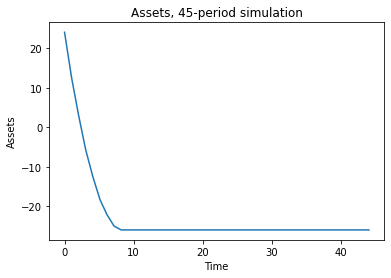

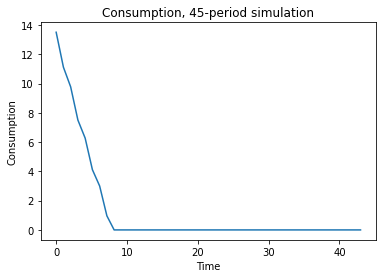

In [14]:
# Discrete method for infinitely-lived agents
a_y = list(product(Y, A, A))
a_y = np.array(a_y)

y = a_y[:,0]
a_i = a_y[:,1]; a_j = a_y[:,2]

c_s = y + (1+r)*a_i - a_j

# Obtaining the utility:
Utility = np.reshape(preferences(c_bar_sat, c_s, pref_type = 'quadratic', sigma = 0.5), (1, 12800))
Utility = np.reshape(Utility, (160, 80))

V_init = np.zeros(160) # initial guess for V

# obtaining W:
def W1(A):   
    return pi[0, 0]*(-0.5*(Y[0] + (1+r)*A - A - c_bar_sat)**2)/(1-beta) + \
           pi[0, 1]*(-0.5*(Y[1] + (1+r)*A - A - c_bar_sat)**2)/(1-beta)
def W2(A):
    return pi[1, 0]*(-0.5*(Y[0] + (1+r)*A - A - c_bar_sat)**2)/(1-beta) + \
           pi[1, 1]*(-0.5*(Y[1] + (1+r)*A - A - c_bar_sat)**2)/(1-beta) # note to self: adjust this for CRRA
                                                                        # wrapping all in a fnct

W1 = np.transpose(np.tile(np.reshape(W1(A), (80,1)), 80))
W2 = np.transpose(np.tile(np.reshape(W2(A), (80,1)), 80))

W = np.reshape([W1, W2], (160,80))

# obtaining X:
X = Utility + beta*W

V_it = np.amax(X, axis = 1) # next guess for V
V_diff = V_init - V_it

# Iterating in the same manner as above until convergence is met (see eps in the parameters chunk of code):
count = 0
while np.any(abs(V_diff) > eps):
    V_ss = V_it
    V_init = np.array([V_ss[0:80], V_ss[80:]])
    
    def W1(V_init):
        return pi[0,0]*V_init[0,:] + pi[0,1]*V_init[1,:]
    def W2(V_init):
        return pi[1,0]*V_init[0,:] + pi[1,1]*V_init[1,:]
    
    W1 = np.reshape(np.tile(np.reshape(W1(V_init), (1,80)), 80), (80,80))
    W2 = np.reshape(np.tile(np.reshape(W2(V_init), (1,80)), 80), (80,80))

    W = np.reshape([W1, W2], (160,80))
    
    X = Utility + beta*W
    
    V_it = np.amax(X, axis = 1)
    V_diff = V_ss - V_it
    
    count += 1
    
# Once convergence is obtained, X will be as desired, and the value functions for the 2 states in the economy are:
V_y_l = V_it[0:80]; V_y_h = V_it[80:]

# The policy function then reads as:
g = np.argmax(X, axis = 1)

a_opt_y_l = A[g[0:80]] # optimal assets levels for whenever y is low
a_opt_y_h = A[g[80:]]  # optimal assets levels for whenever y is high

c_y_l = Y[0]*np.ones(80) + (1+r)*A - a_opt_y_l # consumption levels for whenever y is low
c_y_h = Y[1]*np.ones(80) + (1+r)*A - a_opt_y_h # consumption levels for whenever y is low

# Imposing the non-negativity condition:
c_y_l = [max(i,0) for i in c_y_l]; c_y_h = [max(i,0) for i in c_y_h]; 

# Simulating the time paths for consumption:
y = np.zeros([1, 80])
for i in range(0, 80):    
    y[0, i] = 1  # due to gamma being zero

# Simulating the assets for 45 periods:       
sim = np.zeros(45)
g_y_l = g[0:80]
sim[0] = g_y_l[79] # initial guess of assets  

for i in range(1, 45):
        sim[i] = g_y_l[int(sim[i-1])]
for i in range(0, 44):
        sim[i] = a_opt_y_l[int(sim[i])]
          
t = np.linspace(0, 44, 44)

# Simulating consumption for 45 periods:
c = np.zeros(44)

for i in range(0, 44):
    c[i] = sim[i]*(1+r)+w*y[0, i]-sim[i+1]
    if c[i] <= 0:
        c[i] = 0


# Plotting the optimal policy on consumption for the two possible states on y:
plt.figure()
plt.plot(A, c_y_h, label = 'Optimal consumption $c$ for high $y$')
plt.plot(A, c_y_l, '.', label = 'Optimal consumption $c$ for low $y$')
plt.title('Policy function: consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

# Asset & Consumption simulation:
plt.figure()
plt.plot(t, sim[0:44], label = 'Assets ')
plt.title('Assets, 45-period simulation')
plt.ylabel('Assets')
plt.xlabel('Time')
plt.show()

plt.figure()
plt.plot(t[0:43], c[0:43], label = 'Consumption')
plt.title('Consumption, 45-period simulation')
plt.ylabel('Consumption')
plt.xlabel('Time')
plt.show()

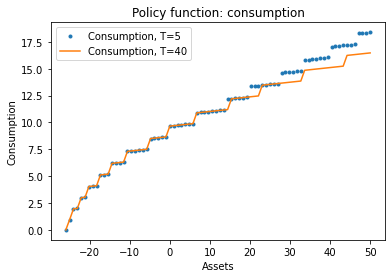

In [22]:
# Finitely-lived households, where W is normalized to 0 in T+1
# Once again, T = 45

# Assets grid for following period, re-initializing:
A = np.linspace(((-(1+r)/r)*Y[0]), 50, 80) # Replacing with (1+r)/r 
                                           # in order to find solution when borrowing not allowed

# A matrix with all possible combinations of assets today and tomorrow:
a_y = list(product(Y, A, A))
a_y = np.array(a_y)

y = a_y[:,0]
a_i = a_y[:,1]; a_j = a_y[:,2]

c_s = y + (1+r)*a_i - a_j

# Obtaining the utility:
Utility = np.reshape(preferences(c_bar_sat, c_s, pref_type = 'quadratic', sigma = 0.5), (1, 12800))
Utility = np.reshape(Utility, (160, 80))

W = np.reshape(np.zeros(160*80), (160,80))

# Re-initializing the counter:
count = 0
f_V = []; f_G = []

for count in range(1, 46):
    # obtaining X, g and W in a similar manner to before:
    X = Utility + beta*W
    g = np.argmax(X, axis = 1)
    W = np.amax(X, axis = 1)
    # storing the value function iterations:
    f_V.append(W); f_G.append(g)
    # reshaping W:
    W = np.transpose(np.tile(np.reshape(W, [160,1]), 80))
    W = np.concatenate((W[:80, :80], W[:80, 80:]))
    count += 1
    
f_V = np.transpose(np.array(f_V)); f_G = np.transpose(np.array(f_G))

# Periods 5 and 40:
A5 = A[f_G[0:80, 5]]; A40 = A[f_G[0:80, 40]] # assets
C5 = Y[0]*np.ones(80) + (1+r)*A - A5; C40 = Y[0]*np.ones(80) + (1+r)*A - A40 # consumption

# Imposing the non-negativity constraint once again:
C5 = [max(i,0) for i in C5]; C40 = [max(i,0) for i in C40]

plt.figure()
plt.plot(A, C5, '.', label = 'Consumption, T=5')
plt.plot(A, C40, label = 'Consumption, T=40')
plt.title('Policy function: consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

### II.4.1. Partial Equilibrium with Uncertainty

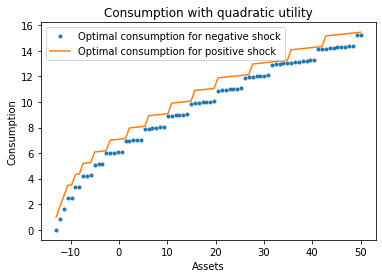

In [44]:
# Infinitely-lived households economy

# re-stating/re-defining the parameters/variables:
gamma = 0.95
sigma_y = 0.5
c_bar_sat = 100
pi = np.array([((1+gamma)/2, (1-gamma)/2),((1-gamma)/2, (1+gamma)/2)])

Y = np.array([1 - sigma_y, 1 + sigma_y])

# Assets grid for following period, re-initializing:
A = np.linspace(((-(1+r)/r)*Y[0]), 50, 80) # Replacing with (1+r)/r 
                                           # in order to find solution when borrowing not allowed

# A matrix with all possible combinations of assets today and tomorrow:
a_y = list(product(Y, A, A))
a_y = np.array(a_y)

y = a_y[:,0]
a_i = a_y[:,1]; a_j = a_y[:,2]

c_s = y + (1+r)*a_i - a_j

# Obtaining the utility:
Utility = np.reshape(preferences(c_bar_sat, c_s, pref_type = 'quadratic', sigma = 0.5), (1, 12800))
Utility = np.reshape(Utility, (160, 80))

V_init = np.zeros(160) # initial guess for V

# Computing W once again:
def W1(A):   
    return pi[0,0]*(-0.5*(Y[0] + (1+r)*A - A - c_bar_sat)**2)/(1-beta) + \
           pi[0,1]*(-0.5*(Y[1] + (1+r)*A - A - c_bar_sat)**2)/(1-beta)
def W2(A):
    return pi[1,0]*(-0.5*(Y[0] + (1+r)*A - A - c_bar_sat)**2)/(1-beta) + \
           pi[1,1]*(-0.5*(Y[1] + (1+r)*A - A - c_bar_sat)**2)/(1-beta)

W1 = np.reshape(np.tile(np.reshape(W1(A), (1,80)), 80), (80,80))
W2 = np.reshape(np.tile(np.reshape(W2(A), (1,80)), 80), (80,80))

W = np.reshape([W1, W2], (160,80))

# Obtaining X and the next iteration as before:
X = Utility + beta*W
V_it = np.amax(X, axis = 1)

V_diff = V_init - V_it
count = 0

# Running until convergence:
# Note to self: also include a max number of iterations param. for further convenience
while np.any(abs(V_diff) > eps):
    V_ss = V_it
    V_init = np.array([V_ss[0:80], V_ss[80:]])
    
    def W1(V_init):
        return pi[0,0]*V_init[0,:] + pi[0,1]*V_init[1,:]
    def W2(V_init):
        return pi[1,0]*V_init[0,:] + pi[1,1]*V_init[1,:]
    
    W1 = np.reshape(np.tile(np.reshape(W1(V_init), (1,80)), 80), (80,80))
    W2 = np.reshape(np.tile(np.reshape(W2(V_init), (1,80)), 80), (80,80))

    W = np.reshape([W1, W2], (160,80))
    
    X = Utility + beta*W
    
    V_it = np.amax(X, axis = 1)
    V_diff = V_ss - V_it
    
    count += 1
    
# Following the convergence, we have the needed value of the matrix X
# Now obtaining the value/policy functions as before:
V_y_l = V_it[0:80]; V_y_h = V_it[80:]
g = np.argmax(X, axis = 1)

# Policy functions on assets/consumption depending on realization of y:
a_opt_y_l = A[g[0:80]]; a_opt_y_h = A[g[80:]]

c_y_l = Y[0]*np.ones(80) + (1+r)*A - a_opt_y_l; c_y_h = Y[1]*np.ones(80) + (1+r)*A - a_opt_y_h

# Plot the value function and the policy function:
plt.figure()
plt.plot(A, c_y_l, '.', label = 'Optimal consumption for negative shock')
plt.plot(A, c_y_h, label = 'Optimal consumption for positive shock')
plt.title('Consumption with quadratic utility')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

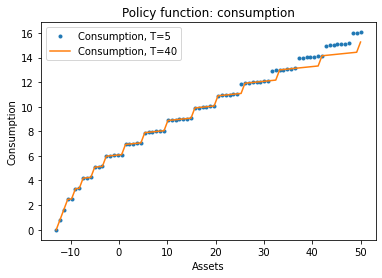

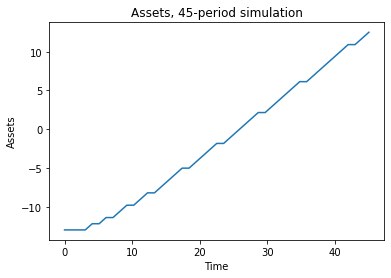

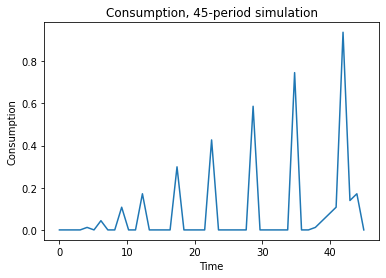

In [45]:
# For the finitely-lived case, where we normalize W to 0 in T+1:

# - re-initializing once again
W = np.reshape(np.zeros(160*80), (160,80))
f_V = []; f_G = []
c = y + (1+r)*a_i-a_j

# Obtaining the utility:
Utility = np.reshape(preferences(c_bar_sat, c_s, pref_type = 'quadratic', sigma = 0.5), (1, 12800))
Utility = np.reshape(Utility, (160, 80))

V_init = np.zeros(160) # initial guess for V

per = 0
for per in range(1, 46):
    # similarly to before:
    X = Utility + beta*W
    g = np.argmax(X, axis = 1); W = np.amax(X, axis = 1)
    
    f_V.append(W); f_G.append(g)
    W = np.transpose(np.tile(np.reshape(W, [160, 1]), 80))
    W = np.concatenate((W[:80, :80], W[:80, 80:]))
    count += 1
    
f_V = np.transpose(np.array(f_V)); f_G = np.transpose(np.array(f_G))

A5 = A[f_G[0:80, 5]]; A40 = A[f_G[0:80, 40]]                                 # -> assets periods 5 and 40, resp.
C5 = Y[0]*np.ones(80) + (1+r)*A - A5; C40 = Y[0]*np.ones(80) + (1+r)*A - A40 # -> consumption periods 5 and 40, resp.

# Simulating shocks, T = 45:
t = np.linspace(0, 45, 45); y = np.zeros([1, 45]); c = np.zeros(45); a_opt = np.zeros([45,1])

for i in range(0, 45):
    y[0, i] = np.random.choice((1 - sigma_y, 1 + sigma_y),\
                                p = ((1+gamma)/2, (1-gamma)/2))

for i in range(0, 45):
    if y[0, i] < 1:
        a_opt[i] = a_opt_y_l[i]
    if y[0, i] > 1:
        a_opt[i] = a_opt_y_h[i]
        
for i in range(0, 44):
    c[i] = a_opt[i]*(1+r) + w*y[0,i] - a_opt[i+1]

# Imposing non-negativity:
c = [max(i,0) for i in c];

# Policy function on consumption:
plt.figure()
plt.plot(A, C5, '.', label = 'Consumption, T=5')
plt.plot(A, C40, label = 'Consumption, T=40')
plt.title('Policy function: consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

# 45-period simulation for assets and capital:
plt.figure()
plt.plot(t, a_opt, label = 'Assets')
plt.title('Assets, 45-period simulation')
plt.ylabel('Assets')
plt.xlabel('Time')
plt.show()

plt.figure()
plt.plot(t, c, label = 'Consumption')
plt.title('Consumption, 45-period simulation')
plt.ylabel('Consumption')
plt.xlabel('Time')
plt.show()


# for the finitely-lived individuals, consumption at T = 5 is higher than consumption in the later period of T = 40
# as opposed to the prev. case

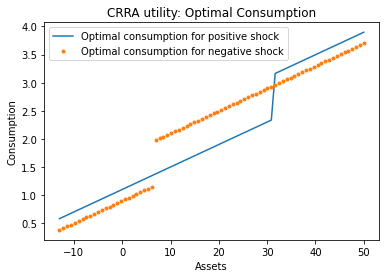

In [35]:
# Increasing/changing prudence (by sigma) for the infinitely-lived agents setting:
sigma = 2; sigma_y = 0.1; gamma = 0;

Y = np.array([1 - sigma_y, 1 + sigma_y])

a_y = list(product(Y, A, A))
a_y = np.array(a_y)

y = a_y[:,0]
a_i = a_y[:,1]; a_j = a_y[:,2]

c_s = y + (1+r)*a_i - a_j; c_bar_sat = 100

V_init = np.zeros(160) # initial guess for V

# Markov Process transition matrix:
pi = np.array([((1+gamma)/2, (1-gamma)/2),((1-gamma)/2, (1+gamma)/2)])

# CRRA utility:
# ---> code for utility needs to be improved, note to self: wrap everything up in a single function
Utility = np.zeros(12800)
for i in range(0, 12800):
    if c_s[i] >=0:
        Utility[i] = preferences(c_bar_sat, c_s[i], pref_type = 'CRRA', sigma = 2)
    else:
        Utility[i] = -10000 # as usual, avoiding negative consumption issues
Utility = np.reshape(np.reshape(Utility, (1,12800)), (160,80))

# The initial guess on the value function
V_init = np.zeros(160)

# Computing W once again:
def W1(A):   
    return pi[0,0]*(((Y[0] + (1+r)*A - A)**(1-sigma))-1)/((1-beta)*(1-sigma)) + \
           pi[0,1]*(((Y[0] + (1+r)*A - A)**(1-sigma))-1)/((1-beta)*(1-sigma))
def W2(A):
    return pi[1,0]*(((Y[0] + (1+r)*A - A)**(1-sigma))-1)/((1-beta)*(1-sigma)) + \
           pi[1,1]*(((Y[0] + (1+r)*A - A)**(1-sigma))-1)/((1-beta)*(1-sigma))

W1 = np.transpose(np.tile(np.reshape(W1(A), (80,1)), 80))
W2 = np.transpose(np.tile(np.reshape(W2(A), (80,1)), 80))

W = np.reshape([W1, W2], (160,80))
        
# Computing X:
X = Utility + beta*W
V_it = np.amax(X, axis = 1)

V_diff = V_init - V_it
count = 0

# Iterating until convergence:
while np.any(abs(V_diff) > eps):
    V_ss = V_it
    V_init = np.array([V_ss[0:80], V_ss[80:]])
    def W1(V_init):
        return pi[0,0]*V_init[0,:] + pi[0,1]*V_init[1,:]
    def W2(V_guess):
        return pi[1,0]*V_init[0,:] + pi[1,1]*V_init[1,:]
    
    W1 = np.reshape(np.tile(np.reshape(W1(V_init), (1,80)), 80), (80,80))
    W2 = np.reshape(np.tile(np.reshape(W2(V_init), (1,80)), 80), (80,80))

    W = np.reshape([W1, W2], (160,80))
    X = Utility + beta*W
    
    V_it = np.amax(X, axis = 1)
    V_diff = V_ss - V_it
    count += 1
    
# We now have X, proceeding to obtain V and g for y_l and y_h:
V_y_l = V_it[0:80]; V_y_h = V_it[80:]
g = np.argmax(X, axis = 1)

# Optimal assets/consumption for the two different realizations on y:
a_opt_y_l = A[g[0:80]]; a_opt_y_h = A[g[80:]]
c_y_l = Y[0]*np.ones(80) + (1+r)*A - a_opt_y_l; c_y_h = Y[1]*np.ones(80) + (1+r)*A - a_opt_y_h

# Imposing non-negativity:
c_y_l = [max(i,0) for i in c_y_l]; c_y_h = [max(i,0) for i in c_y_h]

# Plotting optimal consumption for the different realizations:
plt.figure()
plt.plot(A, c_y_h, label = 'Optimal consumption for positive shock')
plt.plot(A, c_y_l, '.', label = 'Optimal consumption for negative shock')
plt.title('CRRA utility: Optimal Consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

# I think I have misplaced the two definitions -> plot does not look like I would guess 
# -> note to self: if time allows, fix this

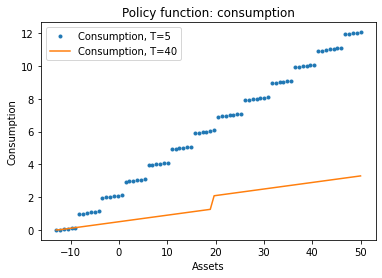

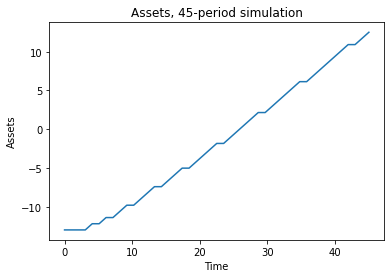

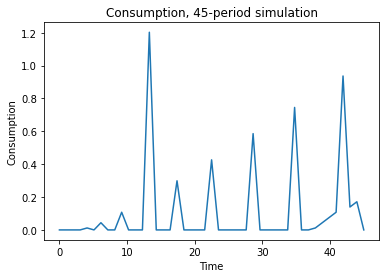

In [47]:
# The finitely-lived households:

W = np.reshape(np.zeros(160*80), (160,80))
f_V = []; f_G = []

Utility = np.zeros(12800)
for i in range(0, 12800):
    if c_s[i] >=0:
        Utility[i] = preferences(c_bar_sat, c_s[i], pref_type = 'CRRA', sigma = 2)
    else:
        Utility[i] = -10000 # as usual, avoiding negative consumption issues
Utility = np.reshape(np.reshape(Utility, (1,12800)), (160,80))

it = 0
for it in range(1, 46):
    X = Utility + beta*W
    g = np.argmax(X, axis = 1)
    W = np.amax(X, axis = 1)
    f_V.append(W); f_G.append(g)
    W = np.transpose(np.tile(np.reshape(W, [160,1]), 80))
    W = np.concatenate((W[:80, :80], W[:80, 80:]))
    it += 1
    
f_V = np.transpose(np.array(f_V)); f_G = np.transpose(np.array(f_G)); 
    
A5 = A[f_G[0:80, 5]]; A40 = A[f_G[0:80, 40]]
C5 = Y[0]*np.ones(80) + (1+r)*A - A5; C40 = Y[0]*np.ones(80) + (1+r)*A - A40

for i in range(0,80):
    
    if C5[i] < 0:
        C5[i] = 0
    
    if C40[i] < 0:
        C40[i] = 0   
        
# Imposing the non-negativity constraint once again:
C5 = [max(i,0) for i in C5]; C40 = [max(i,0) for i in C40]

# Simulating the shocks for T = 45, as well as paths for consumption/assets:
t = np.linspace(0, 45, 45); y = np.zeros([1, 45]); a_opt = np.zeros([45,1]); c = np.zeros(45)

for i in range(0, 45):    
        y[0, i] = np.random.choice((1 - sigma_y, 1 + sigma_y),\
                                p = ((1+gamma)/2, (1-gamma)/2))        
        if y[0, i] < 1:
            a_opt[i] = a_opt_y_l[i]
        if y[0, i] > 1:
            a_opt[i] = a_opt_y_h[i]
        
for i in range(0, 44):
    c[i] = a_opt[i]*(1+r) + w*y[0,i] - a_opt[i+1]
    
c = [max(i,0) for i in c];

# Policy function on consumption:
plt.figure()
plt.plot(A, C5, '.', label = 'Consumption, T=5')
plt.plot(A, C40, label = 'Consumption, T=40')
plt.title('Policy function: consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

# 45-period simulation for assets and capital:
plt.figure()
plt.plot(t, a_opt, label = 'Assets')
plt.title('Assets, 45-period simulation')
plt.ylabel('Assets')
plt.xlabel('Time')
plt.show()

plt.figure()
plt.plot(t, c, label = 'Consumption')
plt.title('Consumption, 45-period simulation')
plt.ylabel('Consumption')
plt.xlabel('Time')
plt.show()

# Precautionary savings here